# MicroB Prediction

__TRIN DATA FEATURES__


row_id,cfips,county,state,first_day_of_month
pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021
pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021
pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021
pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021
median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021

__FROM EXTERNAL__
Total!!Estimate!!Population 18 to 24 years!!Less than high school graduate!
Total!!Estimate!!Population 18 to 24 years!!High school graduate (includes equivalency)!
Total!!Estimate!!Population 18 to 24 years!!Some college or associate's degree!
Total!!Estimate!!Population 18 to 24 years!!Bachelor's degree or higher!

Total!!Estimate!!Population 25 years and over!!9th to 12th grade, no diploma!
Total!!Estimate!!Population 25 years and over!!High school graduate (includes equivalency)
Total!!Margin of Error!!Population 25 years and over!!Some college, no degree!2.png)
Total!!Estimate!!Population 25 years and over!!Associate's degree!
Total!!Estimate!!Population 25 years and over!!Bachelor's degree!
Total!!Estimate!!Population 25 years and over!!Graduate or professional degree!

__PREDICT__
microbusiness_density

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

# Data


In [258]:
df_train = pd.read_csv('/Users/joheunkang/microb/data/train.csv')
df_test = pd.read_csv('/Users/joheunkang/microb/data/test.csv')
df_census = pd.read_csv('/Users/joheunkang/microb/data/census_starter.csv')
df_s_a_edu21 = pd.read_csv('/Users/joheunkang/microb/data/external/state_a_2017_edu/ACSST1Y2017.S1501-Data.csv')


In [337]:
# Covid data 
# data souce : https://github.com/nytimes/covid-19-data
covid_20 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2020.csv")
covid_21 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2021.csv")
covid_22 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2022.csv")
covid_23 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2023.csv")
covid_recent = pd.read_csv("/Users/joheunkang/microb/data/us-counties-recent.csv")

# make class 

In [332]:
class Microb:
  def __init__(self,df,df_1):
    self.df = df  
    self.df1 = df_1

  def change_to_datetime(self):
    self.df['first_day_of_month'] = pd.to_datetime(self.df['first_day_of_month'], format='%Y-%m-%d')
  
  def create_m_year(self,row):
    return  int(row['first_day_of_month'].year)

  def create_m_month(self,row):
    return int(row['first_day_of_month'].month)

  def create_m_day(self,row):
    return int(row['first_day_of_month'].day)
  
  def get_m_year(self):
    self.df['m_year']= self.df.apply(lambda row: self.create_m_year(row),axis = 1)
    self.df['m_month']= self.df.apply(lambda row:self.create_m_month(row),axis = 1)
    self.df['m_day']= self.df.apply(lambda row:self.create_m_day(row),axis = 1)
      
  def get_first_day_of_prev_month(self):
    self.df['first_day_of_p1_m'] = self.df['first_day_of_month'] - pd.DateOffset(months=1)

  def get_first_day_of_prev_year(self):
    self.df['first_day_of_p1_y'] = self.df['first_day_of_month'] - pd.DateOffset(months=12)
  
  def collect_p1_kind(self,row,kind):
    collect_year= row['m_year']
    prev_year = collect_year -1
    if prev_year ==2017:
      return None 
    else: 
      return row[f'pct_{kind}_{prev_year}']


  def merge(self):
    self.df = pd.merge(self.df, self.df1, on = 'cfips')
    
  def collect_p1_median_hh(self,row):
    collect_year= row['m_year']
    prev_year = collect_year -1
    if prev_year ==2017:
      return None 
    else: 
      return row[f'median_hh_inc_{prev_year}']

    
  def get_p1_y_data(self):
    self.df['p1_y_bb'] = self.df.apply(lambda row: self.collect_p1_kind(row,'bb'),axis = 1)
    self.df['p1_y_college'] = self.df.apply(lambda row: self.collect_p1_kind(row,'college'),axis = 1)
    self.df['p1_y_foreign_born'] = self.df.apply(lambda row: self.collect_p1_kind(row,'foreign_born'),axis = 1)
    self.df['p1_y_it_workers'] = self.df.apply(lambda row: self.collect_p1_kind(row,'it_workers'),axis = 1)
    self.df['p1_y_median_hh_inc'] = self.df.apply(lambda row: self.collect_p1_median_hh(row),axis = 1)
    
  def create_p1_m_microb_density(self,row):
    is_exist =self.df[(self.df['cfips']==row['cfips'])&(self.df['first_day_of_month']==row['first_day_of_p1_m'])]
  
    if is_exist: 
      return is_exist['microbusiness_density']
    else: 
      return None
  def get_p1_m_microb_density(self):
    df["p1_m_microb_density"] = self.df.apply(lambda row: self.create_p1_m_microb_density(row),axis = 1)

  def get_df(self):
    return self.df 

In [333]:
d_train= Microb(df_train,df_census)
d_train.change_to_datetime()
d_train.get_m_year()
d_train.get_first_day_of_prev_month()
d_train.get_first_day_of_prev_year()
d_train.merge()
d_train.get_p1_y_data()
# d_train.get_p1_m_microb_density()
d = d_train.get_df()
d.head()

#d_train.get_first_day_of_prev_year()
#d = d_train.get_df()

# d_train.get_first_day_of_prev_year()
# d_train.get_p1_y_data()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,m_year,m_month,m_day,...,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0


In [334]:
print(len(d))

122265


In [335]:
temp = d[['cfips','first_day_of_month','microbusiness_density']]
temp = temp.rename(columns={"first_day_of_month":"first_day_of_p1_m"})
d= d.merge(temp, how='left', on=['cfips','first_day_of_p1_m'])
d= d.rename(columns={"microbusiness_density_y":"p1_m_mcrob_density"})

In [336]:
d.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,3.007682
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,2.884870
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,3.055843
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,2.993233


In [700]:
d.to_csv('d.csv')

p6_m_mcrob_density may needed : most buisness takes 6 month to open

# Covid data
- covid data and given data has different county name: use cfips and fips to merge those to table

In [551]:
df_covid = pd.concat([covid_20,covid_21,covid_22,covid_23,covid_recent],axis = 0)
df_covid.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m
0,2020-01-21 00:00:00,Snohomish,Washington,53061.0,1,0.0,2020.0,1.0,1.0,2020-01-01
1,2020-01-22 00:00:00,Snohomish,Washington,53061.0,1,0.0,2020.0,1.0,1.0,2020-01-01
2,2020-01-23 00:00:00,Snohomish,Washington,53061.0,1,0.0,2020.0,1.0,1.0,2020-01-01
3,2020-01-24 00:00:00,Cook,Illinois,17031.0,1,0.0,2020.0,1.0,1.0,2020-01-01
4,2020-01-24 00:00:00,Snohomish,Washington,53061.0,1,0.0,2020.0,1.0,1.0,2020-01-01


In [558]:
class Covid:
  def __init__(self,df):
    self.df = df
    self.df['date'] = pd.to_datetime(self.df['date'], format='%Y-%m-%d')
  
  def create_m_year(self,row):
    return  int(row['date'].year)

  def create_m_month(self,row):
    return int(row['date'].month)
  
  def get_y_m_d(self):
    self.df['year']= self.df.apply(lambda row: self.create_m_year(row),axis = 1)
    self.df['month']= self.df.apply(lambda row: self.create_m_month(row),axis = 1)
    self.df['day'] = 1
      
#   def create_first_day_of_p1_m(self,row):
#     return pd.to_datetime(str(row['year'])+'-'+str(row['month'])+'-'+str(row['day']),format='%Y-%m-%d')
  
  def get_first_day_of_p1_m(self):  
    def create_first_day_of_p1_m(row):
      return pd.to_datetime(str(row['year'])+'-'+str(row['month'])+'-'+str(row['day']),format='%Y-%m-%d')
    self.df['first_day_of_p1_m'] = self.df.apply(lambda row: create_first_day_of_p1_m(row),axis = 1)
    return self.df 
  
  # collect groupby monthly mean, median for  
  def collect_county_m_case_mean(self):
    return self.df.groupby(['fips','year','month'])[['cases']].mean().rename(columns = {'cases':'county_m_case_mean'}).reset_index()

  def collect_county_m_case_median(self):
    return self.df.groupby(['fips','year','month'])[['cases']].median().rename(columns= {'cases':'county_m_case_median'}).reset_index()

  def collect_county_m_death_mean(self):
    return self.df.groupby(['fips','year','month'])[['deaths']].mean().rename(columns = {'deaths':'county_m_deaths_mean'}).reset_index()

  def collect_county_m_death_median(self):
    return self.df.groupby(['fips','year','month'])[['deaths']].median().rename(columns= {'deaths':'county_m_deaths_median'}).reset_index()
  
  def merge_case_death(self):
    self.df = pd.merge(self.df,self.collect_county_m_case_mean(), on = ['fips','year','month'])
    self.df = pd.merge(self.df,self.collect_county_m_case_median(), on =['fips','year','month'])
    self.df = pd.merge(self.df,self.collect_county_m_death_mean(), on = ['fips','year','month'])
    self.df = pd.merge(self.df,self.collect_county_m_death_median(), on =['fips','year','month'])
  
  def drop_cols(self):
    self.df = self.df.drop(['date', 'cases','deaths'], axis=1)
    self.df = self.df.drop_duplicates()
    
  def get_data(self):
    return self.df 
  


In [560]:
# covid_2020
CovidData= Covid(covid_20)
CovidData.get_y_m_d()
CovidData.get_first_day_of_p1_m()
CovidData.merge_case_death()
df_covid_20 = CovidData.get_first_day_of_p1_m()


In [561]:
df_covid_20.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
3,2020-01-24,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
4,2020-01-25,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0


In [562]:
# covid_2021
CovidData= Covid(covid_21)
CovidData.get_y_m_d()
CovidData.get_first_day_of_p1_m()
CovidData.merge_case_death()
df_covid_21 = CovidData.get_first_day_of_p1_m()

In [563]:
# covid_2022
CovidData= Covid(covid_22)
CovidData.get_y_m_d()
CovidData.get_first_day_of_p1_m()
CovidData.merge_case_death()
df_covid_22 = CovidData.get_first_day_of_p1_m()

In [564]:
# covid_2023
CovidData= Covid(covid_23)
CovidData.get_y_m_d()
CovidData.get_first_day_of_p1_m()
CovidData.merge_case_death()
df_covid_23 = CovidData.get_first_day_of_p1_m()

In [565]:
df_covid_20.to_csv('df_covid_20.csv')
df_covid_21.to_csv('df_covid_21.csv')
df_covid_22.to_csv('df_covid_22.csv')
df_covid_23.to_csv('df_covid_23.csv')

In [566]:
df_covid_20.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
3,2020-01-24,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
4,2020-01-25,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0


In [542]:
merged = merged.drop(columns = ['index'])
merged

,county,state,year,month,county_m_case_mean,county_m_deaths_mean,county_m_case_median,county_m_deaths_median,day,first_day_of_p1_m
0,Abbeville,South Carolina,2020,3,2.461538,0.000000,3.0,0.0,1,2020-03-01
1,Abbeville,South Carolina,2020,4,14.333333,0.000000,10.0,0.0,1,2020-04-01
2,Abbeville,South Carolina,2020,5,34.838710,0.000000,34.0,0.0,1,2020-05-01
3,Abbeville,South Carolina,2020,6,72.900000,0.000000,71.5,0.0,1,2020-06-01
4,Abbeville,South Carolina,2020,7,192.225806,2.096774,170.0,2.0,1,2020-07-01
...,...,...,...,...,...,...,...,...,...,...
115401,Zapata,Texas,2023,2,4469.888889,57.000000,4469.0,57.0,1,2023-02-01
115402,Zavala,Texas,2023,1,4495.129032,70.000000,4496.0,70.0,1,2023-01-01
115403,Zavala,Texas,2023,2,4516.277778,70.000000,4518.0,70.0,1,2023-02-01
115404,Ziebach,South Dakota,2023,1,707.451613,12.903226,707.0,13.0,1,2023-01-01


In [567]:
def drop_covid_duplicates(df):
  return df.drop_duplicates(subset = ['fips','year','month'])

In [568]:
df_covid_20 = drop_covid_duplicates(df_covid_20)
df_covid_21 = drop_covid_duplicates(df_covid_21)
df_covid_22 = drop_covid_duplicates(df_covid_22)
df_covid_23 = drop_covid_duplicates(df_covid_23)


In [574]:
def concat_covid_data(df1,df2,df3,df4):
  df1.rename(columns={'fips':'cfips'})
  df2.rename(columns={'fips':'cfips'})
  df3.rename(columns={'fips':'cfips'})
  df4.rename(columns={'fips':'cfips'})
  return pd.concat([df1,df2,df3,df4],axis = 0)


In [575]:
covid_all = concat_covid_data(df_covid_20,df_covid_21,df_covid_22,df_covid_23)

In [576]:
covid_all.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
11,2020-01-24,Cook,Illinois,17031.0,1,0.0,2020,1,1,2020-01-01,1.25,1.0,0.0,0.0
19,2020-01-25,Orange,California,6059.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
26,2020-01-26,Maricopa,Arizona,4013.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
32,2020-01-26,Los Angeles,California,6037.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0


In [577]:
covid_all.to_csv('covid_all.csv')

In [578]:
covid_all = covid_all.reset_index(drop=True)
covid_all.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
1,2020-01-24,Cook,Illinois,17031.0,1,0.0,2020,1,1,2020-01-01,1.25,1.0,0.0,0.0
2,2020-01-25,Orange,California,6059.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
3,2020-01-26,Maricopa,Arizona,4013.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
4,2020-01-26,Los Angeles,California,6037.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0


In [580]:
print(len(covid_all))

114082


In [586]:
covid_all.head()

,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
1,Cook,Illinois,17031.0,1,0.0,2020,1,1,2020-01-01,1.25,1.0,0.0,0.0
2,Orange,California,6059.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
3,Maricopa,Arizona,4013.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
4,Los Angeles,California,6037.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0


In [ ]:
def drop_covid_date(df):
  return df.drop(columns =['date'])

In [590]:
def rename_fips_2_cfips(df):
  df = df.rename(columns = {'fips':'cfips'})
  df = df.astype({"cfips": int})
  return df 

def merge_with_covid(df,covid_df):
  return pd.merge(df,covid_df,how= "left",on=["cfips","first_day_of_p1_m"]) 

In [587]:
covid_all = rename_fips_2_cfips(covid_all)


In [588]:
covid_all.head()

,county,state,cfips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,Snohomish,Washington,53061,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
1,Cook,Illinois,17031,1,0.0,2020,1,1,2020-01-01,1.25,1.0,0.0,0.0
2,Orange,California,6059,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
3,Maricopa,Arizona,4013,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
4,Los Angeles,California,6037,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0


In [591]:
final_df = merge_with_covid(d,covid_all) ###############merge to make final data ####################3

In [593]:
print(len(final_df))
final_df.head(50)

122265


,row_id,cfips,county_x,state_x,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,state_y,cases,deaths,year,month,day,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,2020,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2020,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227,2020,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255,2020,4,1,...,Alabama,1.0,0.0,2020.0,3.0,1.0,5.375000,6.0,0.000000,0.0
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257,2020,5,1,...,Alabama,10.0,0.0,2020.0,4.0,1.0,24.366667,25.0,1.500000,1.0


In [594]:
final_df.to_csv('final_df.csv')

# New start

In [6]:
final_df = pd.read_csv('final_df.csv',index_col = [0])
final_df.head()


,row_id,cfips,county_x,state_x,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,state_y,cases,deaths,year,month,day,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Drop duplicated columns 

In [7]:
def clean_columns(df):
  df = df.drop(columns = ['county_y','state_y'])
  df = df.rename(columns = {'county_x':'county', 'state_x':'state'})
  return df 


In [8]:
re_df = clean_columns(final_df)

In [9]:
re_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,p1_m_mcrob_density,cases,deaths,year,month,day,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,3.007682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,2.884870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,3.055843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,2.993233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Seasonality Check 

In [10]:
re_df.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density_x', 'active', 'm_year', 'm_month', 'm_day',
       'first_day_of_p1_m', 'first_day_of_p1_y', 'pct_bb_2017', 'pct_bb_2018',
       'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
       'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
       'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021', 'p1_y_bb', 'p1_y_college',
       'p1_y_foreign_born', 'p1_y_it_workers', 'p1_y_median_hh_inc',
       'p1_m_mcrob_density', 'cases', 'deaths', 'year', 'month', 'day',
       'county_m_case_mean', 'county_m_case_median', 'county_

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
def create_data_county_state(df: object,county:str ,state:str) -> object: 
  """
  Create data for seasonlity check
  
  : prarmeter df: object - original data frame
  : parameter county: str - county name
  : parameter state" str - state name 
  
  """
  print(f"county: {county}, state:{state}")
  df = df[(df['county']==county) & (df['state']==state)]
  df_valid = df[10::]
  df_valid = df_valid.reset_index(drop=True)
  
  return df_valid 
  

In [13]:
# seasonality by county 
# get example county and check seasonality 
def check_sesaon(df: object,y: str, lag:int) -> None: 
  print(f'checking seasonaliy on {y}')
  print(len(df))
  df.set_index('first_day_of_month', inplace=True)
  
  analysis = df[[y]].copy()
  #analysis = df[['microbusiness_density_x']].copy()
  
  #analysis = df[['county_m_case_median']].copy()
  #series = [i for i in range(6,17)]
  #decompose_result_mult = seasonal_decompose(analysis,model="Multiplicative",period=12)
  decompose_result_mult = seasonal_decompose(analysis,model="Additive",period=lag)

  trend = decompose_result_mult.trend
  seasonal = decompose_result_mult.seasonal
  residual = decompose_result_mult.resid
  plt.figure(figsize=(25, 2))
  fig = decompose_result_mult.plot()
  #decompose_result_mult.plot()
  fig.set_size_inches((30, 9))
  # Tight layout to realign things
  fig.tight_layout()
  plt.show()


county: Albany County, state:Wyoming
checking seasonaliy on county_m_case_mean
29


<Figure size 1800x144 with 0 Axes>

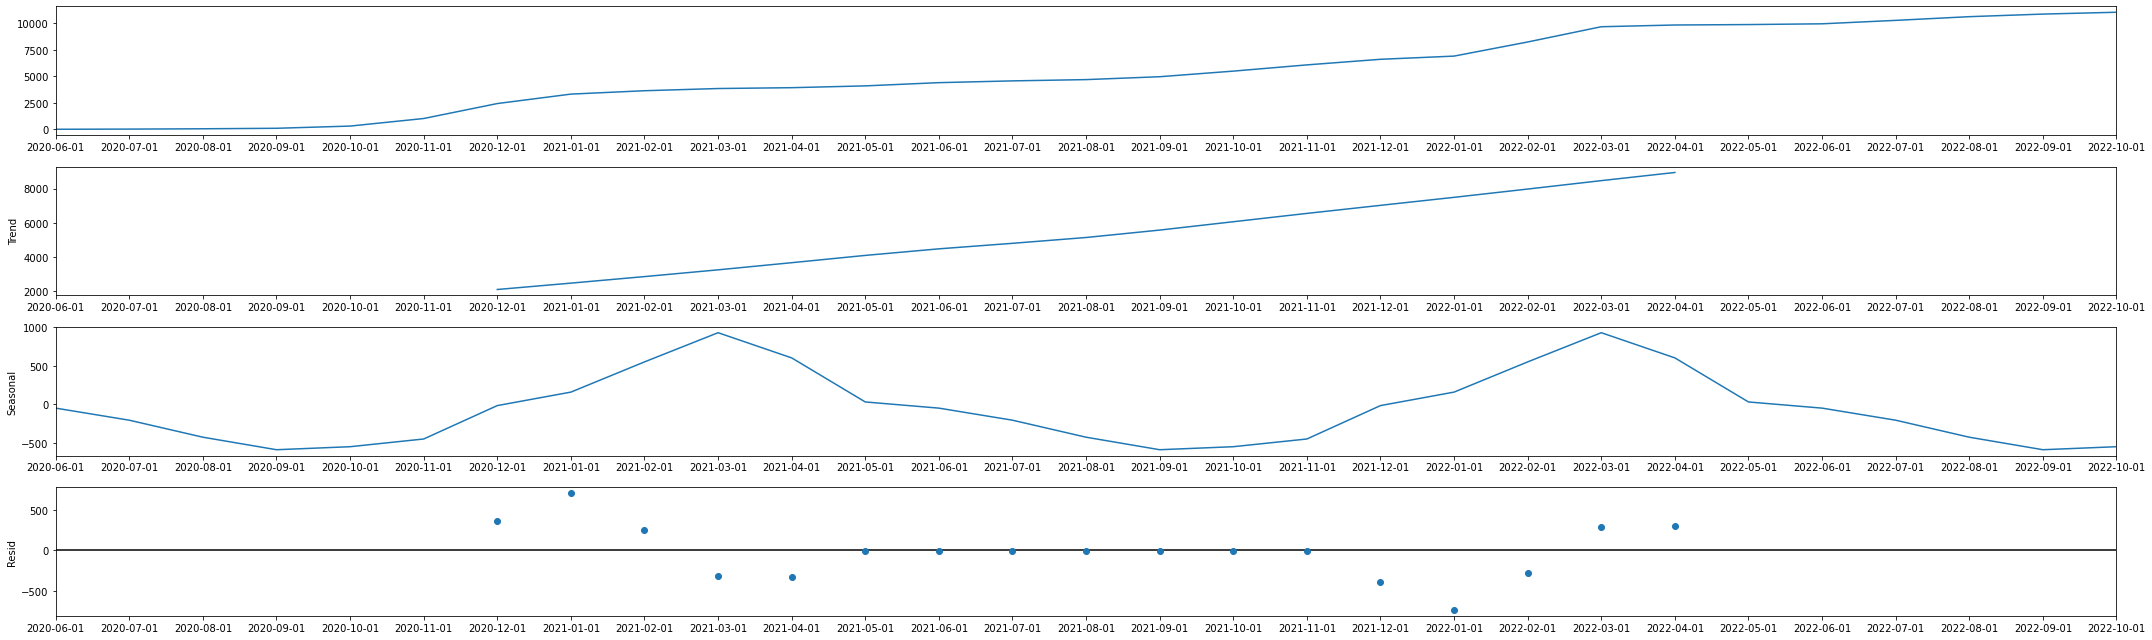

In [14]:
# c_df = create_data_county_state(re_df, 'Orange County', 'California')
c_df = create_data_county_state(re_df, 'Albany County', 'Wyoming')
# bronx , new york 7, 2 lowest 
# Hamilton , newyork 7,1 lowest 
# Los Angeles, California, many diff points 
# Orange ,Califonia, 2 is lowest but much different graph than Los Angeles 
# --> differ by county but they all have seasonality 

check_sesaon(c_df,'county_m_case_mean',12)

### Microb
__each state has their seasonality__: 
for each state, use seasonality. since it has year/month seasonaliyt, we use month and year feature to indicate seasonality

### Covid 
- mean death and mean cases has it's own seasonality for each county

https://towardsdatascience.com/taking-seasonality-into-consideration-for-time-series-analysis-4e1f4fbb768f

__county_m_case_median__ also has year seasonality (but all counties are similar)

stationary vs non-stationary : looks like none stationary because each year has differnt value 

multiplicative vs additive : ? 

## Augmented Dickey-Fuller Test (ADF Test)
https://medium.com/swlh/seasonality-analysis-and-forecast-in-time-series-b8fbba820327

- to check stationary: we canot create a time series model unless our series is stationary
if not stationary, we have to make the sereis stationary

A stationary series is one in which the properties — mean, variance and covariance, do not vary with time.

The null(H0) and alternate hypothesis(H1) of this test are:

H0: The series has a unit root (value of a =1),the series is non-stationary.

H1: The series has no unit root, the series is stationary.

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
def adf_test(data):
  print('adf testing')
  test_res = adfuller(data['microbusiness_density_x'],autolag = "AIC")
  # 'AIC': auto lag calculation
  # return: adf(test statistics), pvalue, usedlag, nobs(number of observations used for adf regression and calc of critical value )
  # critical values, 1,5,10 level, icvest: max info criterion of autolag is not None, resstre: dummyclasse 
  return test_res


  

p_val: 0.557 > 1% and 5% and 10% and p>0.05 -> we cannot reject H0-> __None stationary__
if the data is none stationary, we can fit __ARMIA__ and __Seasonal ARIMA (SARMIMA)__

# Feature Engineering 

In [168]:
re_df.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density_x', 'active', 'm_year', 'm_month', 'm_day',
       'first_day_of_p1_m', 'first_day_of_p1_y', 'pct_bb_2017', 'pct_bb_2018',
       'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
       'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
       'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021', 'p1_y_bb', 'p1_y_college',
       'p1_y_foreign_born', 'p1_y_it_workers', 'p1_y_median_hh_inc',
       'p1_m_mcrob_density', 'cases', 'deaths', 'year', 'month', 'day',
       'county_m_case_mean', 'county_m_case_median', 'county_

In [18]:
df_fe = re_df.drop(columns=["row_id", "cfips", "active", 'pct_bb_2017', 'pct_bb_2018',
       'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
       'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
       'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021','cases', 'deaths', 'year', 'month', 'day',
        "first_day_of_p1_m","first_day_of_p1_y"
])
df_fe.head()

,county,state,first_day_of_month,microbusiness_density_x,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,Autauga County,Alabama,2019-08-01,3.007682,2019,8,1,78.9,15.9,2.0,1.1,58786.0,NaN,NaN,NaN,NaN,NaN
1,Autauga County,Alabama,2019-09-01,2.884870,2019,9,1,78.9,15.9,2.0,1.1,58786.0,3.007682,NaN,NaN,NaN,NaN
2,Autauga County,Alabama,2019-10-01,3.055843,2019,10,1,78.9,15.9,2.0,1.1,58786.0,2.884870,NaN,NaN,NaN,NaN
3,Autauga County,Alabama,2019-11-01,2.993233,2019,11,1,78.9,15.9,2.0,1.1,58786.0,3.055843,NaN,NaN,NaN,NaN
4,Autauga County,Alabama,2019-12-01,2.993233,2019,12,1,78.9,15.9,2.0,1.1,58786.0,2.993233,NaN,NaN,NaN,NaN


In [19]:
print(len(df_fe))

122265


# Feature Encoding 

In [20]:
# unneccesary: row_id, cfips, first_day_of_month, 'pct_bb_2017', 'pct_bb_2018',
#        'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
#        'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
#        'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
#        'pct_foreign_born_2019', 'pct_foreign_born_2020',
#        'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
#        'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
#        'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
#        'median_hh_inc_2020', 'median_hh_inc_2021','cases', 'deaths', 'year', 'month', 'day',

# categorical variables (nominal: no numeric realationship): county, state 
# oridnal: year, 


In [21]:
# onehot encoder for county and state (nominal)
one_hot_encoded_data = pd.get_dummies(df_fe, columns = ['county', 'state'])
one_hot_encoded_data

,first_day_of_month,microbusiness_density_x,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,2019-08-01,3.007682,2019,8,1,78.9,15.9,2.0,1.1,58786.0,...,0,0,0,0,0,0,0,0,0,0
1,2019-09-01,2.884870,2019,9,1,78.9,15.9,2.0,1.1,58786.0,...,0,0,0,0,0,0,0,0,0,0
2,2019-10-01,3.055843,2019,10,1,78.9,15.9,2.0,1.1,58786.0,...,0,0,0,0,0,0,0,0,0,0
3,2019-11-01,2.993233,2019,11,1,78.9,15.9,2.0,1.1,58786.0,...,0,0,0,0,0,0,0,0,0,0
4,2019-12-01,2.993233,2019,12,1,78.9,15.9,2.0,1.1,58786.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,2022-06-01,1.803249,2022,6,1,81.3,13.9,1.6,0.0,65566.0,...,0,0,0,0,0,0,0,0,0,1
122261,2022-07-01,1.803249,2022,7,1,81.3,13.9,1.6,0.0,65566.0,...,0,0,0,0,0,0,0,0,0,1
122262,2022-08-01,1.785395,2022,8,1,81.3,13.9,1.6,0.0,65566.0,...,0,0,0,0,0,0,0,0,0,1
122263,2022-09-01,1.785395,2022,9,1,81.3,13.9,1.6,0.0,65566.0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
df_fe.head()

,county,state,first_day_of_month,microbusiness_density_x,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,Autauga County,Alabama,2019-08-01,3.007682,2019,8,1,78.9,15.9,2.0,1.1,58786.0,NaN,NaN,NaN,NaN,NaN
1,Autauga County,Alabama,2019-09-01,2.884870,2019,9,1,78.9,15.9,2.0,1.1,58786.0,3.007682,NaN,NaN,NaN,NaN
2,Autauga County,Alabama,2019-10-01,3.055843,2019,10,1,78.9,15.9,2.0,1.1,58786.0,2.884870,NaN,NaN,NaN,NaN
3,Autauga County,Alabama,2019-11-01,2.993233,2019,11,1,78.9,15.9,2.0,1.1,58786.0,3.055843,NaN,NaN,NaN,NaN
4,Autauga County,Alabama,2019-12-01,2.993233,2019,12,1,78.9,15.9,2.0,1.1,58786.0,2.993233,NaN,NaN,NaN,NaN


In [23]:
df_fe.to_csv('df_fe.csv')

In [24]:
print(len(df_fe))

122265


# Drop rows that contain nan

In [25]:
df_fe_no_nan = df_fe.dropna(axis = 0)
print(len(df_fe_no_nan))

95287


In [26]:
95287/122265 * 100 # only drops 22 percent of the data when remove the nan value rows 

77.93481372428741

# Train and Test Data

In [27]:
test_data = df_fe_no_nan[(df_fe_no_nan['m_year']==2022)&(df_fe_no_nan['m_month']==10)] 
train_data= df_fe_no_nan[(df_fe_no_nan['m_year']!=2022)|(df_fe_no_nan['m_month']!=10)]

In [28]:
print(len(test_data))
print(len(train_data))

3125
92162


In [29]:
print(test_data.columns) == print(train_data.columns)

Index(['county', 'state', 'first_day_of_month', 'microbusiness_density_x',
       'm_year', 'm_month', 'm_day', 'p1_y_bb', 'p1_y_college',
       'p1_y_foreign_born', 'p1_y_it_workers', 'p1_y_median_hh_inc',
       'p1_m_mcrob_density', 'county_m_case_mean', 'county_m_case_median',
       'county_m_deaths_mean', 'county_m_deaths_median'],
      dtype='object')
Index(['county', 'state', 'first_day_of_month', 'microbusiness_density_x',
       'm_year', 'm_month', 'm_day', 'p1_y_bb', 'p1_y_college',
       'p1_y_foreign_born', 'p1_y_it_workers', 'p1_y_median_hh_inc',
       'p1_m_mcrob_density', 'county_m_case_mean', 'county_m_case_median',
       'county_m_deaths_mean', 'county_m_deaths_median'],
      dtype='object')


True

# Time realated features Encoding 

- https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/

In [30]:
from sklego.preprocessing import RepeatingBasisFunction

In [31]:
train_data.dtypes

county                      object
state                       object
first_day_of_month          object
microbusiness_density_x    float64
m_year                       int64
m_month                      int64
m_day                        int64
p1_y_bb                    float64
p1_y_college               float64
p1_y_foreign_born          float64
p1_y_it_workers            float64
p1_y_median_hh_inc         float64
p1_m_mcrob_density         float64
county_m_case_mean         float64
county_m_case_median       float64
county_m_deaths_mean       float64
county_m_deaths_median     float64
dtype: object

In [32]:
train_data['first_day_of_month']= pd.to_datetime(train_data['first_day_of_month'])
trainData = train_data.reset_index(drop=True)

In [33]:
test_data['first_day_of_month']= pd.to_datetime(test_data['first_day_of_month'])
testData = test_data.reset_index(drop=True)

In [34]:
print(len(trainData.columns) == len(testData.columns))

True


In [35]:
train_data.columns

Index(['county', 'state', 'first_day_of_month', 'microbusiness_density_x',
       'm_year', 'm_month', 'm_day', 'p1_y_bb', 'p1_y_college',
       'p1_y_foreign_born', 'p1_y_it_workers', 'p1_y_median_hh_inc',
       'p1_m_mcrob_density', 'county_m_case_mean', 'county_m_case_median',
       'county_m_deaths_mean', 'county_m_deaths_median'],
      dtype='object')

# time numberical encoding

In [36]:
range_of_dates = pd.date_range(start="2020-04-01",end="2022-09-01",freq = 'MS')
X = pd.DataFrame(index=range_of_dates)
X["day_nr"] = range(len(X))
X["day_of_year"] = X.index.day_of_year

In [37]:
rbf = RepeatingBasisFunction(n_periods=1,column="day_of_year",input_range=(1,12),remainder="drop")
#print(rbf)
rbf.fit(X)
X_3 = pd.DataFrame(index=X.index,data=rbf.transform(X))

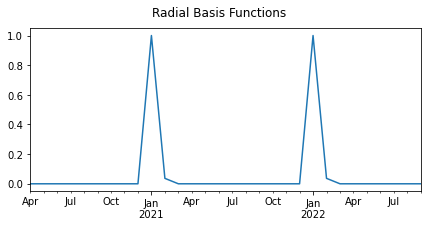

In [38]:
X_3.plot(subplots=True, figsize=(7, 3),sharex=True, title="Radial Basis Functions",legend=False);

In [39]:
# Create a new column with index values
X_3['index_column'] = X_3.index
X_3=X_3.reset_index()


In [40]:
X_3 = X_3.drop(columns = ['index_column'])
X_3 = X_3.rename(columns ={'index':'first_day_of_month',0:'first_day_of_month_fe'})
X_3.head()

,first_day_of_month,first_day_of_month_fe
0,2020-04-01,1.069183e-23
1,2020-05-01,3.720076e-44
2,2020-06-01,4.394446e-72
3,2020-07-01,1.116588e-105
4,2020-08-01,3.514398e-147


In [41]:
# join trainData and X_3 on first day of month


In [44]:
f_train = pd.merge(trainData,X_3,how = 'left',on = 'first_day_of_month')



In [45]:
f_test = pd.merge(testData,X_3,how = 'left',on= 'first_day_of_month')


In [46]:
print(list(f_test.columns)==list(f_train.columns))

True


# process categorical features 

In [47]:
# onehot encoder
from sklearn.preprocessing import OneHotEncoder


In [48]:
f_test.columns = f_train.columns

In [49]:
f_test

,county,state,first_day_of_month,microbusiness_density_x,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,first_day_of_month_fe
0,Autauga County,Alabama,2022-10-01,3.463856,2022,10,1,85.5,16.4,2.1,1.1,62660.0,3.442677,18264.400000,18303.0,225.833333,227.0,NaN
1,Baldwin County,Alabama,2022-10-01,8.359798,2022,10,1,87.9,20.6,3.5,1.3,64346.0,8.341701,65196.833333,65353.0,704.766667,705.0,NaN
2,Barbour County,Alabama,2022-10-01,1.232074,2022,10,1,64.6,6.7,2.6,0.8,36422.0,1.206827,6838.366667,6873.0,101.366667,101.0,NaN
3,Bibb County,Alabama,2022-10-01,1.287240,2022,10,1,74.6,7.9,1.1,2.1,54277.0,1.315346,7461.833333,7481.0,106.533333,107.0,NaN
4,Blount County,Alabama,2022-10-01,1.831783,2022,10,1,81.0,9.3,4.5,0.9,52830.0,1.852060,16746.333333,16793.0,255.433333,256.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,Sweetwater County,Wyoming,2022-10-01,2.823801,2022,10,1,88.4,12.4,5.5,1.0,76668.0,2.811320,12111.466667,12117.0,130.000000,130.0,NaN
3121,Teton County,Wyoming,2022-10-01,26.273220,2022,10,1,90.5,38.3,11.1,2.0,94498.0,26.090586,11596.200000,11583.0,16.000000,16.0,NaN
3122,Uinta County,Wyoming,2022-10-01,4.009369,2022,10,1,90.6,12.3,2.9,0.9,75106.0,3.995591,6098.100000,6102.0,40.600000,41.0,NaN
3123,Washakie County,Wyoming,2022-10-01,3.126551,2022,10,1,85.4,17.2,1.0,1.1,62271.0,3.209264,2643.933333,2642.0,47.000000,47.0,NaN


In [50]:
f_train[f_train.isna().any(axis=1)]
f_train = f_train.dropna()

In [51]:
f_train_unncess = f_train[['first_day_of_month','m_year','m_month','m_day']]

In [52]:
f_train_unncess

,first_day_of_month,m_year,m_month,m_day
0,2020-04-01,2020,4,1
1,2020-05-01,2020,5,1
2,2020-06-01,2020,6,1
3,2020-07-01,2020,7,1
4,2020-08-01,2020,8,1
...,...,...,...,...
92157,2022-05-01,2022,5,1
92158,2022-06-01,2022,6,1
92159,2022-07-01,2022,7,1
92160,2022-08-01,2022,8,1


In [53]:
f_train.head()

,county,state,first_day_of_month,microbusiness_density_x,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,first_day_of_month_fe
0,Autauga County,Alabama,2020-04-01,3.000167,2020,4,1,80.6,16.1,2.3,0.7,58731.0,2.933231,5.375000,6.0,0.000000,0.0,1.069183e-23
1,Autauga County,Alabama,2020-05-01,3.004948,2020,5,1,80.6,16.1,2.3,0.7,58731.0,3.000167,24.366667,25.0,1.500000,1.0,3.720076e-44
2,Autauga County,Alabama,2020-06-01,3.019292,2020,6,1,80.6,16.1,2.3,0.7,58731.0,3.004948,118.064516,110.0,3.451613,3.0,4.394446e-72
3,Autauga County,Alabama,2020-07-01,3.083837,2020,7,1,80.6,16.1,2.3,0.7,58731.0,3.019292,370.333333,370.5,7.600000,6.5,1.116588e-105
4,Autauga County,Alabama,2020-08-01,3.174679,2020,8,1,80.6,16.1,2.3,0.7,58731.0,3.083837,781.967742,780.0,17.774194,20.0,3.514398e-147


In [54]:
# onehot encoder for county and state (nominal)
oh_trainData = pd.get_dummies(f_train, columns = ['county', 'state'])
#oh_testData = pd.get_dummies(f_test, columns = ['county', 'state'])

In [55]:
#drop_columns = ['first_day_of_month','m_year','m_month','m_day']
#curr_df = oh_trainData.drop(columns = drop_columns)


# Numeric Featuer Normalization

In [56]:
from sklearn import preprocessing


In [58]:
numerical_cols = ['p1_y_bb', 'p1_y_college', 'p1_y_foreign_born', 'p1_y_it_workers', 'p1_y_median_hh_inc', 'p1_m_mcrob_density', 'county_m_case_mean', 'county_m_case_median', 'county_m_deaths_mean', 'county_m_deaths_median', 'first_day_of_month_fe']
label_cols = ["microbusiness_density_x"]
unness_cols = ['first_day_of_month','m_year','m_month','m_day']
categorical_cols = set(oh_trainData.columns) - set(numerical_cols)-set(label_cols)-set(unness_cols)
print(len(categorical_cols))



1915


In [65]:
cat_df = oh_trainData[categorical_cols]

In [66]:
num_cols_df  = oh_trainData[numerical_cols]
col_names_num = num_cols_df.columns

In [67]:
label_df = oh_trainData["microbusiness_density_x"]

In [68]:
x = num_cols_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled,columns = col_names_num)

In [69]:
df_scaled

,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,first_day_of_month_fe
0,0.735614,0.354626,0.042593,0.046053,0.297913,0.013063,0.000001,0.000001,0.000000,0.000000,1.069183e-23
1,0.735614,0.354626,0.042593,0.046053,0.297913,0.013361,0.000007,0.000007,0.000046,0.000030,3.720076e-44
2,0.735614,0.354626,0.042593,0.046053,0.297913,0.013383,0.000035,0.000032,0.000105,0.000091,4.394446e-72
3,0.735614,0.354626,0.042593,0.046053,0.297913,0.013447,0.000110,0.000110,0.000231,0.000197,1.116588e-105
4,0.735614,0.354626,0.042593,0.046053,0.297913,0.013734,0.000232,0.000232,0.000539,0.000607,3.514398e-147
...,...,...,...,...,...,...,...,...,...,...,...
92129,0.746501,0.306167,0.029630,0.000000,0.346835,0.007872,0.000472,0.000472,0.000546,0.000546,2.272945e-43
92130,0.746501,0.306167,0.029630,0.000000,0.346835,0.008031,0.000472,0.000472,0.000546,0.000546,4.482005e-71
92131,0.746501,0.306167,0.029630,0.000000,0.346835,0.008031,0.000482,0.000485,0.000570,0.000576,1.869880e-104
92132,0.746501,0.306167,0.029630,0.000000,0.346835,0.008031,0.000505,0.000507,0.000596,0.000607,9.824326e-146


In [71]:
final  = pd.concat([cat_df,df_scaled],axis =1)
final = pd.concat([final,f_train_unncess],axis = 1)

In [72]:
print(list(final.columns))

['county_Jasper County', 'county_Sedgwick County', 'county_Cerro Gordo County', 'county_Broome County', 'county_Inyo County', 'county_Crosby County', 'county_Borden County', 'county_Grady County', 'county_Rio Blanco County', 'county_Centre County', 'county_Cochise County', 'county_San Diego County', 'county_Menifee County', 'county_Union County', 'county_Taliaferro County', 'county_Eau Claire County', 'county_Pennington County', 'county_St. James Parish', 'county_Loving County', 'state_Rhode Island', 'county_Obion County', 'county_Tarrant County', 'county_Lac qui Parle County', 'county_Andrew County', 'county_Norfolk County', 'county_Grand County', 'county_Marinette County', 'county_Pueblo County', 'county_McDonough County', 'county_Wasatch County', 'county_Concho County', 'county_Schuylkill County', 'county_Las Animas County', 'county_Henrico County', 'county_Hopkins County', 'county_Moniteau County', 'county_Knox County', 'county_Terry County', 'county_Coffey County', 'county_Ritchie

In [73]:
final

,county_Jasper County,county_Sedgwick County,county_Cerro Gordo County,county_Broome County,county_Inyo County,county_Crosby County,county_Borden County,county_Grady County,county_Rio Blanco County,county_Centre County,...,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,first_day_of_month_fe,first_day_of_month,m_year,m_month,m_day
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013063,0.000001,0.000001,0.000000,0.000000,1.069183e-23,2020-04-01,2020.0,4.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013361,0.000007,0.000007,0.000046,0.000030,3.720076e-44,2020-05-01,2020.0,5.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013383,0.000035,0.000032,0.000105,0.000091,4.394446e-72,2020-06-01,2020.0,6.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013447,0.000110,0.000110,0.000231,0.000197,1.116588e-105,2020-07-01,2020.0,7.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013734,0.000232,0.000232,0.000539,0.000607,3.514398e-147,2020-08-01,2020.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-01,2022.0,5.0,1.0
92158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-01,2022.0,6.0,1.0
92159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-01,2022.0,7.0,1.0
92160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-01,2022.0,8.0,1.0


In [74]:
final = final.dropna()


In [75]:
final.dtypes

county_Jasper County                float64
county_Sedgwick County              float64
county_Cerro Gordo County           float64
county_Broome County                float64
county_Inyo County                  float64
                                  ...      
first_day_of_month_fe               float64
first_day_of_month           datetime64[ns]
m_year                              float64
m_month                             float64
m_day                               float64
Length: 1930, dtype: object

In [76]:
import datetime

In [77]:
final = final.astype({"first_day_of_month": str})

In [78]:
final

,county_Jasper County,county_Sedgwick County,county_Cerro Gordo County,county_Broome County,county_Inyo County,county_Crosby County,county_Borden County,county_Grady County,county_Rio Blanco County,county_Centre County,...,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,first_day_of_month_fe,first_day_of_month,m_year,m_month,m_day
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013063,0.000001,0.000001,0.000000,0.000000,1.069183e-23,2020-04-01,2020.0,4.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013361,0.000007,0.000007,0.000046,0.000030,3.720076e-44,2020-05-01,2020.0,5.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013383,0.000035,0.000032,0.000105,0.000091,4.394446e-72,2020-06-01,2020.0,6.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013447,0.000110,0.000110,0.000231,0.000197,1.116588e-105,2020-07-01,2020.0,7.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013734,0.000232,0.000232,0.000539,0.000607,3.514398e-147,2020-08-01,2020.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007872,0.000472,0.000472,0.000546,0.000546,2.272945e-43,2022-05-01,2022.0,5.0,1.0
92130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008031,0.000472,0.000472,0.000546,0.000546,4.482005e-71,2022-06-01,2022.0,6.0,1.0
92131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008031,0.000482,0.000485,0.000570,0.000576,1.869880e-104,2022-07-01,2022.0,7.0,1.0
92132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008031,0.000505,0.000507,0.000596,0.000607,9.824326e-146,2022-08-01,2022.0,8.0,1.0


In [79]:
test = final[final['first_day_of_month'] == '2022-09-01']
test

,county_Jasper County,county_Sedgwick County,county_Cerro Gordo County,county_Broome County,county_Inyo County,county_Crosby County,county_Borden County,county_Grady County,county_Rio Blanco County,county_Centre County,...,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,first_day_of_month_fe,first_day_of_month,m_year,m_month,m_day
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015248,0.005284,0.005267,0.006723,0.006735,6.521222e-194,2022-09-01,2022.0,9.0,1.0
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.037816,0.018784,0.018732,0.020996,0.021025,6.521222e-194,2022-09-01,2022.0,9.0,1.0
88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005330,0.001930,0.001918,0.003062,0.003064,6.521222e-194,2022-09-01,2022.0,9.0,1.0
118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005758,0.002115,0.002101,0.003186,0.003186,6.521222e-194,2022-09-01,2022.0,9.0,1.0
148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008178,0.004837,0.004817,0.007597,0.007615,6.521222e-194,2022-09-01,2022.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012395,0.003380,0.003401,0.003823,0.003823,1.869880e-104,2022-09-01,2022.0,9.0,1.0
92044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.114245,0.003127,0.003137,0.000485,0.000485,1.869880e-104,2022-09-01,2022.0,9.0,1.0
92074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017733,0.001754,0.001755,0.001183,0.001183,9.824326e-146,2022-09-01,2022.0,9.0,1.0
92103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013924,0.000723,0.000734,0.001335,0.001335,1.869880e-104,2022-09-01,2022.0,9.0,1.0


In [80]:
final_train_data = final.drop(columns = ['first_day_of_month','m_year','m_month','m_day'])
final_test_data = test.drop(columns = ['first_day_of_month','m_year','m_month','m_day'])

In [81]:
final_train_data

,county_Jasper County,county_Sedgwick County,county_Cerro Gordo County,county_Broome County,county_Inyo County,county_Crosby County,county_Borden County,county_Grady County,county_Rio Blanco County,county_Centre County,...,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,first_day_of_month_fe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.354626,0.042593,0.046053,0.297913,0.013063,0.000001,0.000001,0.000000,0.000000,1.069183e-23
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.354626,0.042593,0.046053,0.297913,0.013361,0.000007,0.000007,0.000046,0.000030,3.720076e-44
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.354626,0.042593,0.046053,0.297913,0.013383,0.000035,0.000032,0.000105,0.000091,4.394446e-72
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.354626,0.042593,0.046053,0.297913,0.013447,0.000110,0.000110,0.000231,0.000197,1.116588e-105
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.354626,0.042593,0.046053,0.297913,0.013734,0.000232,0.000232,0.000539,0.000607,3.514398e-147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.306167,0.029630,0.000000,0.346835,0.007872,0.000472,0.000472,0.000546,0.000546,2.272945e-43
92130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.306167,0.029630,0.000000,0.346835,0.008031,0.000472,0.000472,0.000546,0.000546,4.482005e-71
92131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.306167,0.029630,0.000000,0.346835,0.008031,0.000482,0.000485,0.000570,0.000576,1.869880e-104
92132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.306167,0.029630,0.000000,0.346835,0.008031,0.000505,0.000507,0.000596,0.000607,9.824326e-146


# Test data processing

# Model Fitting 
- since their seasonality is strong, we may not need complicated model: try simple models such as linear regression,lasso, ridge regresson, svm, polynomial, 
- then try tree methods 
- we won't need any complicated deep learning model for this problem 

In [82]:
from statsmodels.tsa.arima_model import ARIMA

In [83]:
arima_model = ARIMA(final_train_data['microbusiness_density_x'],
                      order=(1,1,1))
arima_result = arima_model.fit()


KeyError: 'microbusiness_density_x'

In [ ]:
df['forecast']=arima_model.predict(start=90,end=103,dynamic=True)
df[['forecast']].plot(figsize=(12,8))